# FinGPT Sentiment Analysis & Price Forecasting

This notebook uses:
1. **FinGPT Sentiment** - For sentiment classification of financial news
2. **FinGPT Forecaster** - For predicting actual price changes

Both models run locally on your Mac (M-series with MPS acceleration).

**Memory Optimized Version:** Models are loaded one at a time and unloaded after use to fit within 24GB RAM.

In [1]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType

#other needed packages
import re
import os

# Set JAVA_HOME for PySpark
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17'

spark = SparkSession.builder \
    .appName("stock market preds") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/18 04:07:52 WARN Utils: Your hostname, Jeffreys-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.17 instead (on interface en0)
26/01/18 04:07:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/18 04:07:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# functions to import data, run SQL from file and save back to file
def import_csv_to_table(table_name, file, format_cols):
    df = spark.read.csv(file, header=True, quote="\"",
                        escape="\"", multiLine=True, inferSchema=True)
    if format_cols:
        cols_formatted = [re.sub(r"[^a-zA-Z0-9\s]", "", col_name).lower().replace(" ", "_") for col_name in df.columns]
        df = df.toDF(*cols_formatted)
    df.createOrReplaceTempView(f"{table_name}")
    return df

def sql_step(file):
    with open(file, 'r', encoding='utf-8') as f:
        sql_text = f.read()
    return spark.sql(sql_text)

In [3]:
news = import_csv_to_table("news", "raw_data/news_data.csv", False)
stocks = import_csv_to_table("stocks", "raw_data/stock_data.csv", False)

In [4]:
feature_set = sql_step("sql/sentiment_data_prep_fingpt.sql")
feature_set.show(10, truncate=False)

+---------------+------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+
|news_article_id|symbol|news_date |article_text                                                                                                                                                                                                                                                                                                                                                            |percent_daily_price_change|
+---------------+------+----------+---------------------------------------------------------------------------------------------------------------------

In [5]:
# Setup device (MPS for M-series Mac, CUDA for GPU, CPU as fallback)
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
PyTorch version: 2.9.1


In [ ]:
# FinGPT Sentiment Scoring Function (model loaded on-demand)
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import pandas as pd
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

# Updated to use available FinGPT models on Hugging Face
# Using Llama2 7B version from oliverwang15 (the FinGPT author)
BASE_MODEL = "NousResearch/Llama-2-7b-hf"
SENTIMENT_ADAPTER = "oliverwang15/FinGPT_v32_Llama2_Sentiment_Instruction_LoRA_FT"

def load_fingpt_sentiment():
    """Load FinGPT Sentiment model."""
    print("Loading FinGPT Sentiment model...")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
    tokenizer.pad_token = tokenizer.eos_token
    
    # Load base model first without device_map
    model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True
    )
    
    # Apply LoRA adapter
    model = PeftModel.from_pretrained(model, SENTIMENT_ADAPTER)
    model.eval()
    
    # Move to MPS after adapter is applied
    model = model.to("mps")
    
    print("FinGPT Sentiment model loaded successfully!")
    return tokenizer, model

def unload_model(model, tokenizer):
    """Unload model and free memory."""
    del model
    del tokenizer
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Model unloaded and memory freed.")

def score_sentiment_fingpt(article_text, tokenizer, model, max_length=512):
    """Score sentiment using FinGPT model."""
    prompt = f"""Instruction: What is the sentiment of this news? Please choose an answer from {{negative/neutral/positive}}.
Input: {article_text[:500]}
Answer: """
    
    try:
        inputs = tokenizer(prompt, return_tensors="pt", max_length=max_length, truncation=True)
        inputs = {k: v.to("mps") for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = response.split("Answer:")[-1].strip().lower()
        
        if "positive" in answer:
            return "positive", 0.85
        elif "negative" in answer:
            return "negative", 0.85
        else:
            return "neutral", 0.7
    except Exception as e:
        print(f"Error: {e}")
        return "neutral", 0.5

print("Sentiment functions defined.")

/Users/jeffreyvananderson/Library/CloudStorage/OneDrive-Personal/stock_market_preds_v1/.venv3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentiment functions defined.


In [7]:
# Authenticate with Hugging Face using API key
from huggingface_hub import login
import json

with open("api_keys.json", "r") as f:
    api_keys = json.load(f)

login(token=api_keys["HUGGINGFACE_KEY"])
print("Successfully logged in to Hugging Face!")

Successfully logged in to Hugging Face!


In [ ]:
# Clear any leftover memory before loading model
import gc
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
print("Memory cleared before model loading!")

Memory cleared before model loading!


In [9]:
# STEP 1: Score all articles with FinGPT Sentiment
# Model is loaded, used, then unloaded to free memory

df = feature_set.toPandas()
print(f"Total articles to score: {len(df)}")

# Load sentiment model
tokenizer_sentiment, model_sentiment = load_fingpt_sentiment()

# Test on a sample first
test_text = "Goldman Sachs upgrades Apple to Buy rating with price target of $200"
sentiment, conf = score_sentiment_fingpt(test_text, tokenizer_sentiment, model_sentiment)
print(f"Test: '{test_text}'")
print(f"Sentiment: {sentiment}, Confidence: {conf}\n")

# Score all articles
sentiments, sentiment_confs = [], []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Scoring Sentiment"):
    text = row['article_text']
    sent, sent_conf = score_sentiment_fingpt(text, tokenizer_sentiment, model_sentiment)
    sentiments.append(sent)
    sentiment_confs.append(sent_conf)

df['sentiment'] = sentiments
df['sentiment_confidence'] = sentiment_confs

print(f"\nSentiment distribution:\n{df['sentiment'].value_counts()}")

# Unload sentiment model to free memory for forecaster
unload_model(model_sentiment, tokenizer_sentiment)

Total articles to score: 35430
Loading FinGPT Sentiment model...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 19.36it/s]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FinGPT Sentiment model loaded successfully!
Test: 'Goldman Sachs upgrades Apple to Buy rating with price target of $200'
Sentiment: neutral, Confidence: 0.7



Scoring Sentiment: 100%|██████████| 35430/35430 [7:54:11<00:00,  1.25it/s]  



Sentiment distribution:
sentiment
neutral     35118
positive      165
negative      147
Name: count, dtype: int64
Model unloaded and memory freed.


In [10]:
# Save checkpoint after sentiment scoring (before forecaster)
os.makedirs("processed_data", exist_ok=True)
checkpoint_file = "processed_data/fingpt_sentiment_checkpoint.csv"
df.to_csv(checkpoint_file, index=False)
print(f"Checkpoint saved: {checkpoint_file} ({len(df)} rows with sentiment scores)")

Checkpoint saved: processed_data/fingpt_sentiment_checkpoint.csv (35430 rows with sentiment scores)


In [ ]:
# Aggressively clear memory before loading forecaster
import gc

# Delete sentiment model if it exists
if 'model_sentiment' in dir():
    del model_sentiment
if 'tokenizer_sentiment' in dir():
    del tokenizer_sentiment

# Force garbage collection multiple times
for _ in range(3):
    gc.collect()

# Clear MPS cache
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
    torch.mps.synchronize()

print("Memory aggressively cleared!")

Memory aggressively cleared!


In [18]:
# FinGPT Forecaster Functions
# Note: There's no official FinGPT forecaster LoRA available on HuggingFace
# We'll use the sentiment model with a different prompt for price prediction
import signal

FORECASTER_ADAPTER = "oliverwang15/FinGPT_v32_Llama2_Sentiment_Instruction_LoRA_FT"

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

def load_fingpt_forecaster():
    """Load FinGPT Forecaster model (using sentiment model with price prediction prompt)."""
    print("Loading FinGPT Forecaster model...")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
    tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True
    )
    model = PeftModel.from_pretrained(model, FORECASTER_ADAPTER)
    model.eval()
    model = model.to("mps")
    print("FinGPT Forecaster model loaded successfully!")
    return tokenizer, model

def predict_price_change_fingpt(article_text, symbol, tokenizer, model, max_length=512, timeout_sec=30):
    """Predict price direction using FinGPT Forecaster with timeout."""
    prompt = f"""Instruction: Based on the following news, predict if the stock price will go up, down, or stay stable. Answer with: up/down/stable.
Company: {symbol}
News: {article_text[:400]}
Prediction: """
    
    try:
        # Set timeout
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(timeout_sec)
        
        inputs = tokenizer(prompt, return_tensors="pt", max_length=max_length, truncation=True)
        inputs = {k: v.to("mps") for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=15,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        
        signal.alarm(0)  # Cancel timeout
        
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = response.split("Prediction:")[-1].strip().lower()
        
        if "up" in answer:
            return "up", 0.7
        elif "down" in answer:
            return "down", 0.7
        else:
            return "stable", 0.6
    except TimeoutException:
        signal.alarm(0)
        print(f"Timeout on article for {symbol}, skipping...")
        return "stable", 0.5
    except Exception as e:
        signal.alarm(0)
        print(f"Error: {e}")
        return "stable", 0.5

print("Forecaster functions defined.")

Forecaster functions defined.


In [21]:
# STEP 2: Predict price direction with FinGPT Forecaster
# Sentiment model was unloaded, now load forecaster

# Load forecaster model
tokenizer_forecast, model_forecast = load_fingpt_forecaster()

# Test on a sample first
test_text = "Apple reports record quarterly earnings beating analyst expectations"
direction, conf = predict_price_change_fingpt(test_text, "AAPL", tokenizer_forecast, model_forecast)
print(f"Test: '{test_text}'")
print(f"Predicted direction: {direction}, Confidence: {conf}\n")

# Predict for all articles
predictions, prediction_confs = [], []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Predicting Price Direction"):
    text = row['article_text']
    symbol = row['symbol']
    pred, pred_conf = predict_price_change_fingpt(text, symbol, tokenizer_forecast, model_forecast)
    predictions.append(pred)
    prediction_confs.append(pred_conf)

df['predicted_direction'] = predictions
df['prediction_confidence'] = prediction_confs

print(f"\nPrediction distribution:\n{df['predicted_direction'].value_counts()}")

# Unload forecaster model to free memory
unload_model(model_forecast, tokenizer_forecast)

Loading FinGPT Forecaster model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


FinGPT Forecaster model loaded successfully!
Test: 'Apple reports record quarterly earnings beating analyst expectations'
Predicted direction: stable, Confidence: 0.6



Predicting Price Direction: 100%|██████████| 35430/35430 [9:20:53<00:00,  1.05it/s]   



Prediction distribution:
predicted_direction
stable    35430
Name: count, dtype: int64
Model unloaded and memory freed.


In [22]:
df.head(10)

,news_article_id,symbol,news_date,article_text,percent_daily_price_change,sentiment,sentiment_confidence,predicted_direction,prediction_confidence
0,48346820,LII,2025-10-22,"Headline: Earnings Scheduled For October 22, 2...",-0.013263,neutral,0.7,stable,0.6
1,48346820,SF,2025-10-22,"Headline: Earnings Scheduled For October 22, 2...",-0.000508,neutral,0.7,stable,0.6
2,48931230,VRT,2025-11-18,Headline: 10 Industrials Stocks With Whale Ale...,-0.097841,neutral,0.7,stable,0.6
3,47070626,AAON,2025-08-12,Headline: Mercury Systems Posts Better-Than-Ex...,-0.041960,neutral,0.7,stable,0.6
4,49699047,TSLA,2026-01-05,Headline: EXCLUSIVE: Top 20 Most-Searched Tick...,-0.010301,neutral,0.7,stable,0.6
5,48191292,GS,2025-10-14,"Headline: Earnings Scheduled For October 14, 2...",-0.016311,neutral,0.7,stable,0.6
6,49031186,ADC,2025-11-24,Headline: Congressional Trading Report: Rep. L...,0.001867,neutral,0.7,stable,0.6
7,48333748,NDAQ,2025-10-21,Headline: Gold Sinks 5% On Worst Day In 5 Year...,0.012194,neutral,0.7,stable,0.6
8,49132138,ZS,2025-12-01,Headline: 5 Stock Picks Last Month From Wall S...,0.012171,neutral,0.7,stable,0.6
9,48615046,CRUS,2025-11-04,"Headline: Earnings Scheduled For November 4, 2...",-0.011582,neutral,0.7,stable,0.6


In [23]:
# Export results
os.makedirs("processed_data", exist_ok=True)
df.to_csv("processed_data/fingpt_news_classifications.csv", index=False)
print(f"Exported {len(df)} rows to processed_data/fingpt_news_classifications.csv")

Exported 35430 rows to processed_data/fingpt_news_classifications.csv


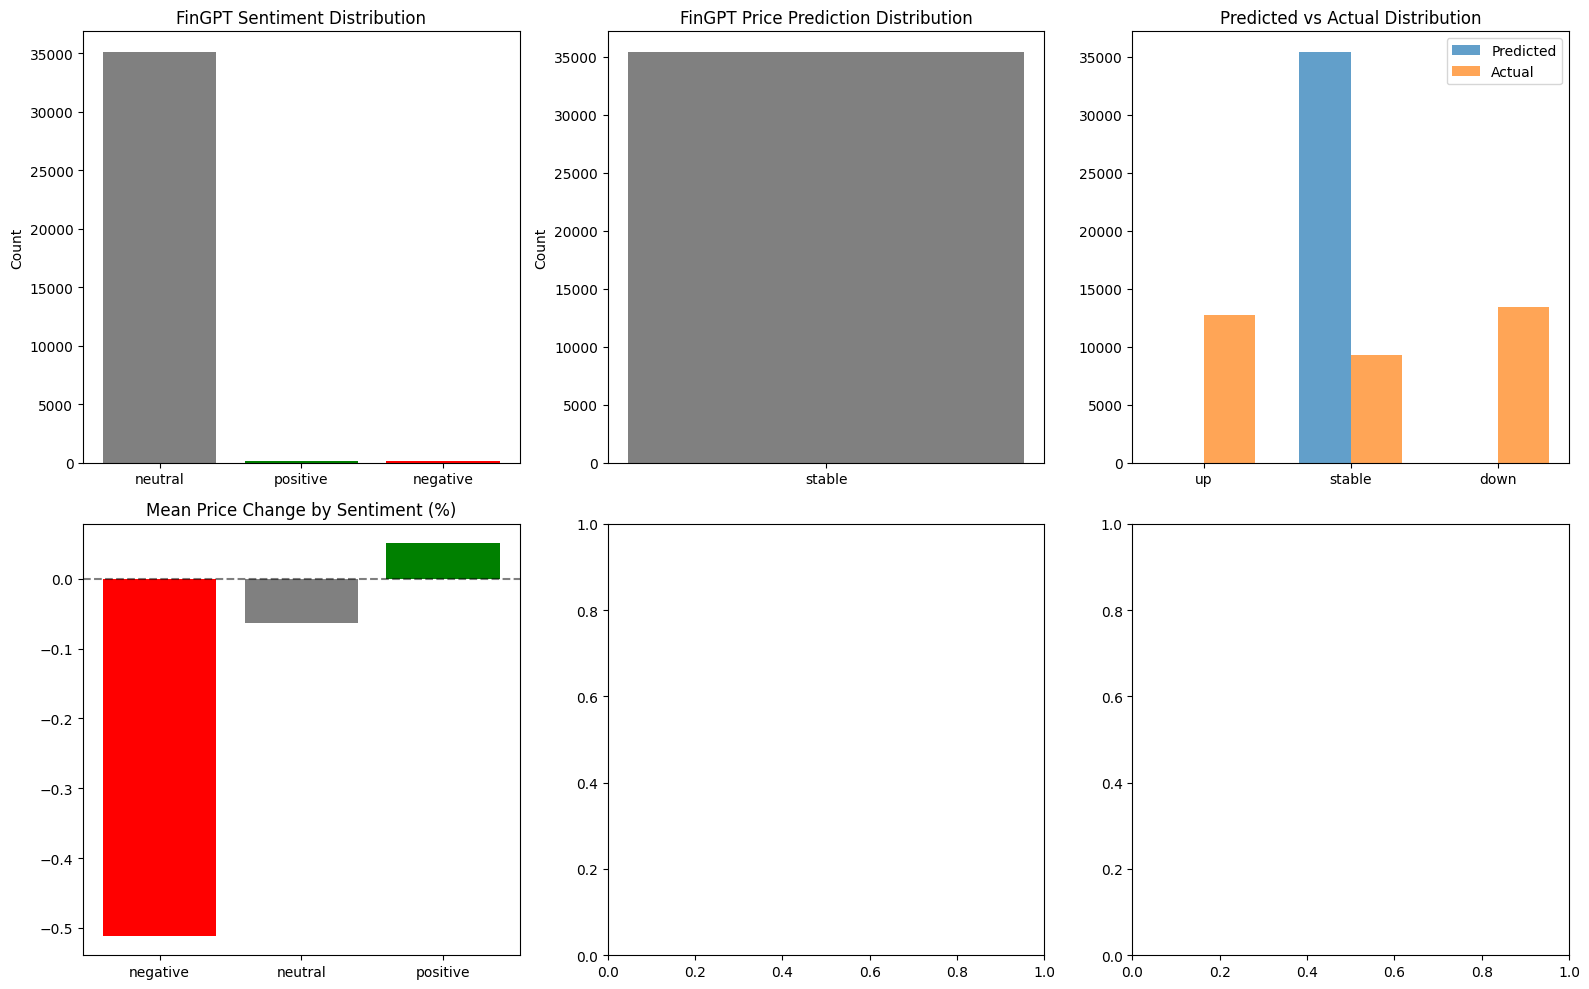

FINGPT PERFORMANCE SUMMARY

Total articles analyzed: 35430

Sentiment Distribution:
  positive  :   165 (  0.5%) - Mean price change: +0.051%
  neutral   : 35118 ( 99.1%) - Mean price change: -0.064%
  negative  :   147 (  0.4%) - Mean price change: -0.511%

Prediction Accuracy (up/down only):


In [24]:
# Evaluate FinGPT Performance
import matplotlib.pyplot as plt
import numpy as np

# Calculate actual direction
df['actual_direction'] = df['percent_daily_price_change'].apply(
    lambda x: 'up' if x > 0.005 else ('down' if x < -0.005 else 'stable')
)

# Binary accuracy (up/down only, excluding stable)
df_binary = df[df['predicted_direction'] != 'stable'].copy()
df_binary['actual_binary'] = df_binary['percent_daily_price_change'].apply(lambda x: 'up' if x > 0 else 'down')
df_binary['correct'] = df_binary['predicted_direction'] == df_binary['actual_binary']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Sentiment Distribution
sent_counts = df['sentiment'].value_counts()
colors_sent = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
axes[0,0].bar(sent_counts.index, sent_counts.values, color=[colors_sent[s] for s in sent_counts.index])
axes[0,0].set_title('FinGPT Sentiment Distribution')
axes[0,0].set_ylabel('Count')

# 2. Prediction Distribution
pred_counts = df['predicted_direction'].value_counts()
colors_pred = {'up': 'green', 'stable': 'gray', 'down': 'red'}
axes[0,1].bar(pred_counts.index, pred_counts.values, color=[colors_pred.get(p, 'blue') for p in pred_counts.index])
axes[0,1].set_title('FinGPT Price Prediction Distribution')
axes[0,1].set_ylabel('Count')

# 3. Actual vs Predicted
actual_counts = df['actual_direction'].value_counts()
x = np.arange(3)
width = 0.35
labels = ['up', 'stable', 'down']
pred_vals = [pred_counts.get(l, 0) for l in labels]
actual_vals = [actual_counts.get(l, 0) for l in labels]
axes[0,2].bar(x - width/2, pred_vals, width, label='Predicted', alpha=0.7)
axes[0,2].bar(x + width/2, actual_vals, width, label='Actual', alpha=0.7)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(labels)
axes[0,2].set_title('Predicted vs Actual Distribution')
axes[0,2].legend()

# 4. Price Change by Sentiment
means = df.groupby('sentiment')['percent_daily_price_change'].mean() * 100
axes[1,0].bar(means.index, means.values, color=[colors_sent[s] for s in means.index])
axes[1,0].set_title('Mean Price Change by Sentiment (%)')
axes[1,0].axhline(0, color='black', linestyle='--', alpha=0.5)

# 5. Prediction Accuracy by Direction
if len(df_binary) > 0:
    acc_by_pred = df_binary.groupby('predicted_direction')['correct'].mean() * 100
    axes[1,1].bar(acc_by_pred.index, acc_by_pred.values, color=[colors_pred.get(p, 'blue') for p in acc_by_pred.index])
    axes[1,1].axhline(50, color='red', linestyle='--', label='Random baseline')
    axes[1,1].set_title('Prediction Accuracy by Direction (%)')
    axes[1,1].legend()

# 6. Confusion Matrix
from sklearn.metrics import confusion_matrix
if len(df_binary) > 0:
    cm = confusion_matrix(df_binary['actual_binary'], df_binary['predicted_direction'], labels=['up', 'down'])
    im = axes[1,2].imshow(cm, cmap='Blues')
    axes[1,2].set_xticks([0, 1])
    axes[1,2].set_yticks([0, 1])
    axes[1,2].set_xticklabels(['Up', 'Down'])
    axes[1,2].set_yticklabels(['Up', 'Down'])
    axes[1,2].set_xlabel('Predicted')
    axes[1,2].set_ylabel('Actual')
    axes[1,2].set_title('Confusion Matrix')
    for i in range(2):
        for j in range(2):
            axes[1,2].text(j, i, cm[i, j], ha='center', va='center', 
                          color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# Summary Statistics
print("="*70)
print("FINGPT PERFORMANCE SUMMARY")
print("="*70)
print(f"\nTotal articles analyzed: {len(df)}")
print(f"\nSentiment Distribution:")
for s in ['positive', 'neutral', 'negative']:
    count = len(df[df['sentiment'] == s])
    pct = count / len(df) * 100
    mean_change = df[df['sentiment'] == s]['percent_daily_price_change'].mean() * 100
    print(f"  {s:10}: {count:5} ({pct:5.1f}%) - Mean price change: {mean_change:+.3f}%")

print(f"\nPrediction Accuracy (up/down only):")
if len(df_binary) > 0:
    overall_acc = df_binary['correct'].mean() * 100
    print(f"  Overall: {overall_acc:.1f}%")
    for pred in ['up', 'down']:
        subset = df_binary[df_binary['predicted_direction'] == pred]
        if len(subset) > 0:
            acc = subset['correct'].mean() * 100
            print(f"  {pred:10}: {acc:.1f}% ({len(subset)} predictions)")

In [25]:
# Compare Sentiment vs Forecaster accuracy
print("\n" + "="*70)
print("SENTIMENT vs FORECASTER COMPARISON")
print("="*70)

# Sentiment-based direction
df['sentiment_direction'] = df['sentiment'].map({'positive': 'up', 'negative': 'down', 'neutral': 'stable'})
df_sent_binary = df[df['sentiment'] != 'neutral'].copy()
df_sent_binary['actual_binary'] = df_sent_binary['percent_daily_price_change'].apply(lambda x: 'up' if x > 0 else 'down')
df_sent_binary['sent_correct'] = df_sent_binary['sentiment_direction'] == df_sent_binary['actual_binary']

print(f"\nSentiment-based accuracy (pos/neg → up/down): {df_sent_binary['sent_correct'].mean()*100:.1f}%")
if len(df_binary) > 0:
    print(f"Forecaster accuracy (up/down predictions):     {df_binary['correct'].mean()*100:.1f}%")

print("\nNote: If both are around 50%, news sentiment may not strongly predict next-day returns.")


SENTIMENT vs FORECASTER COMPARISON

Sentiment-based accuracy (pos/neg → up/down): 51.9%

Note: If both are around 50%, news sentiment may not strongly predict next-day returns.


In [ ]:
# DEBUG: Check what the forecaster was outputting (without re-running inference)
# Since all predictions are "stable", the model is likely outputting sentiment words, not direction words

print("="*70)
print("DEBUG: Investigating 100% stable predictions")
print("="*70)

# Check prediction distribution
print(f"\nPrediction distribution:")
print(df['predicted_direction'].value_counts())

print(f"\nPrediction confidence distribution:")
print(df['prediction_confidence'].value_counts())

# If all confidence values are 0.6 (the default for "stable"), that confirms the issue
stable_count = len(df[df['predicted_direction'] == 'stable'])
conf_06_count = len(df[df['prediction_confidence'] == 0.6])

print(f"\n{'='*70}")
print("DIAGNOSIS:")
print("="*70)

if stable_count == len(df):
    print(f"""
⚠️  ALL {stable_count} predictions are 'stable'!

This confirms the problem: The FinGPT model was fine-tuned for SENTIMENT 
(positive/neutral/negative), NOT price direction (up/down/stable).

When asked "predict if stock will go up, down, or stable", the model outputs
sentiment words like 'neutral' or 'positive' - which don't contain 'up' or 'down',
so the parsing logic defaults to 'stable'.

SOLUTION: Skip the forecaster entirely. Just map sentiment → direction:
  - positive → up  
  - negative → down
  - neutral → stable

The sentiment analysis IS the prediction. Running it twice with different 
prompts doesn't help - it's the same model with the same training.
""")
else:
    print(f"Some non-stable predictions exist. Distribution above shows the breakdown.")